## Feed forward neural network

In [ ]:
from data_processing import process_dataframe

In [8]:
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

import matplotlib.pyplot as plt
import numpy as np
from subprocess import call
import warnings
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pandas as pd

warnings.filterwarnings("ignore")  # specify to ignore warning messages
from keras.optimizers import SGD
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from pandas import DataFrame
from keras.layers import TimeDistributed
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
#from keras.layers.core import Lambda
from keras import backend as K
from netCDF4 import Dataset
from netCDF4 import getlibversion
from keras.models import load_model

In [2]:
SEED = 42

### Load dataset

In [3]:
# Load in data to a pandas dataframe
df = pd.read_pickle('/Users/lb962/Documents/GitHub/ArcticTurbulence/data/ml_ready/merged_arctic.pkl')
df.reset_index(drop=True, inplace=True)

# First, group by 'profile' and 'cruise'
grouped = df.groupby(['profile', 'cruise'])

# Function to subsample every 10 meters
def subsample(group):
    # Round depth to nearest 10 meters
    group = group.copy()
    group['depth_rounded'] = (group['depth'] / 10).round() * 10
    # Drop duplicates on the rounded depth
    return group.drop_duplicates(subset='depth_rounded')

# Apply subsampling to each group
df = grouped.apply(subsample).reset_index(drop=True)

# Exploration
The data is quite imbalanced and has two peaks and is heavily imbalanced towards the lower values. Deal with class imbalance by a transformation towards a Gaussian, weighted loss or doing stratified binning.

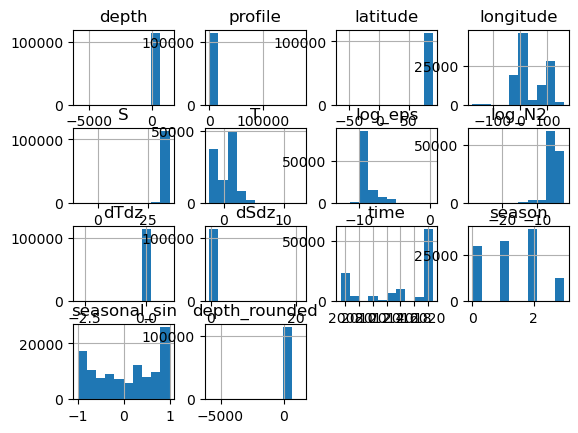

In [13]:
hist = df.hist(bins=10)

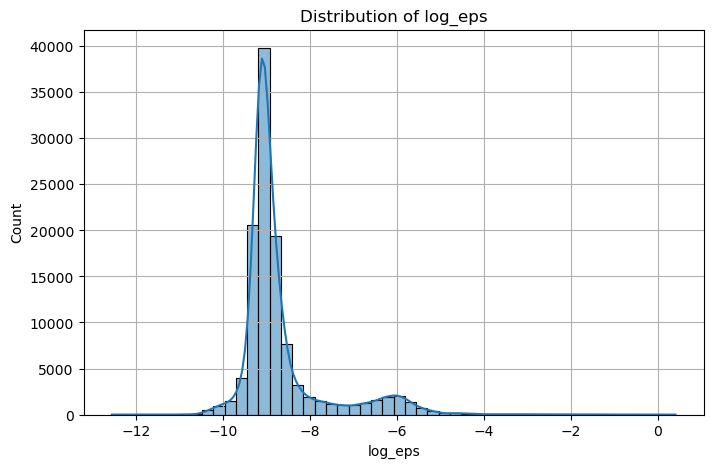

Mean: -8.696001702011108
Median: -9.012893312721982
Standard Deviation: 0.9952482261406205
Min: -12.56578254699707
Max: 0.4047824189666426
Skewness: 2.3264639302232077
Kurtosis: 6.228676465087021
10th percentile: -9.349059254684011
90th percentile: -7.222668561574938


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['log_eps'], bins=50, kde=True)
plt.title('Distribution of log_eps')
plt.xlabel('log_eps')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Basic statistics
print("Mean:", df['log_eps'].mean())
print("Median:", df['log_eps'].median())
print("Standard Deviation:", df['log_eps'].std())
print("Min:", df['log_eps'].min())
print("Max:", df['log_eps'].max())

# Skewness
print("Skewness:", df['log_eps'].skew())

# Kurtosis (how 'peaky' the distribution is)
print("Kurtosis:", df['log_eps'].kurtosis())

# Percentiles
print("10th percentile:", np.percentile(df['log_eps'], 10))
print("90th percentile:", np.percentile(df['log_eps'], 90))

# Split
First attempt with class imbalance

In [4]:
#xstringlist = ['S','T','lat','hab','z','dSdz','dTdz','log_N2_sort']
xstringlist = ['S','T','latitude','dSdz','dTdz', 'log_N2']
ystringlist = ['log_eps']

# First, get the unique profiles
profiles = df['profile'].unique()

# Split profiles into train and temp (test + val)
profiles_train, profiles_temp = train_test_split(
    profiles, test_size=0.4, random_state=SEED)

# Split temp into validation and test
profiles_val, profiles_test = train_test_split(
    profiles_temp, test_size=0.5, random_state=SEED)

# Now, select rows where profile is in the corresponding set
train_df = df[df['profile'].isin(profiles_train)]
val_df = df[df['profile'].isin(profiles_val)]
test_df = df[df['profile'].isin(profiles_test)]

# Now select x and y
X_train = train_df[xstringlist]
y_train = train_df[ystringlist]

X_val = val_df[xstringlist]
y_val = val_df[ystringlist]

X_test = test_df[xstringlist]
y_test = test_df[ystringlist]


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler_range = MinMaxScaler()
scaler_range.fit(X_train)
df_train_scaled_range = pd.DataFrame(scaler_range.transform(X_train))
df_test_scaled_range = pd.DataFrame(scaler_range.transform(X_test))

### Model configurations

In [6]:
activ = 'tanh'#'softsign'#
opt='Adam'
pat=30
n_epochs = 1000
val_split=.15
dropout_fraction=.2
n_units1 =35
n_units2 =35
# n_units3 =n_unit

batch_size = 16

### Define model

In [ ]:
def PermaDropout(rate):
    return Lambda(lambda x: K.dropout(x, level=rate))

# number of input variables
n_var_in = X_train.shape[1]

regr = MLPRegressor(random_state=1, max_iter=100).fit(X_train, y_train)

In [ ]:
y_pred = regr.predict(X_test)
y_pred = pd.DataFrame(y_pred, columns=['log_eps']) 

u = ((y_test - y_pred) ** 2).sum()
v = ((y_test - y_test.mean()) ** 2).sum()
score = 1 - (u/v)
print("R2 prediction score is:", score)

print("MSE:", mean_squared_error(y_test, y_pred))

print("MAE:", mean_absolute_error(y_test, y_pred))

R2 prediction score is: log_eps    0.57851
dtype: float64
MSE: 0.2959589734748027
MAE: 0.33742917392055083


NOTE: R2 score is negative, caution for non-linear regression...
R2 is defined on the fact that the total number of squares (total variation in data) of a fitted model is equal to explained sum of squares (variation in fitted model) plus residual sum of squares (variation not explained by fitted model).

$$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$$ ($Eq_1$)

So, negative $R^2$ if residual sum of squares exceeds total number of squares. This is mathematically impossible, thus it means that $Eq_1$ does not hold true, so total number of squares is no longer the sum.

Reason for this could be that SS_tot is calculated using just the data, whereas SS_res depends on model predictions and the data. So eq1 holds for models trained on the same data, not for using test_data.

# Deal with class imbalance of epsilon

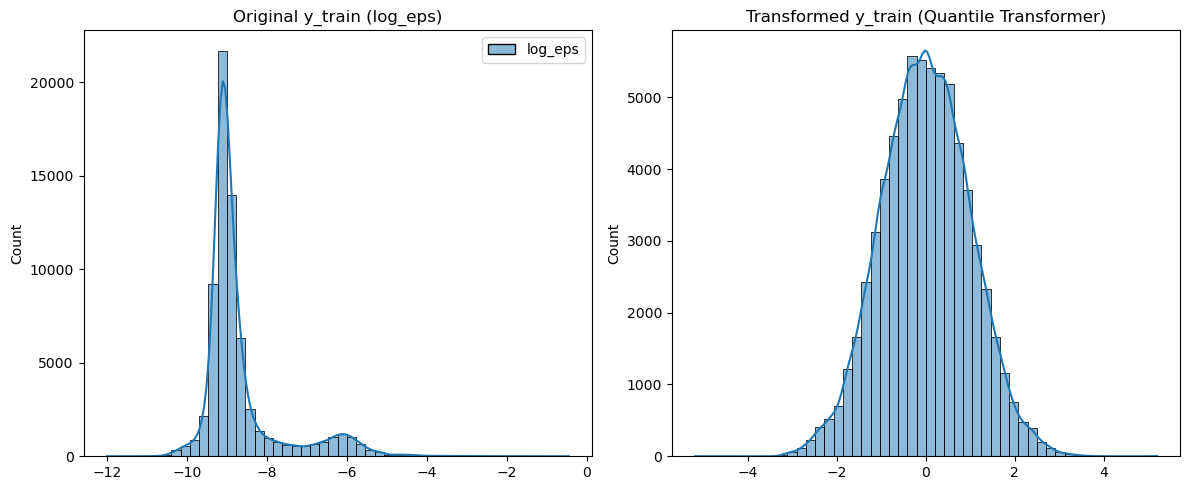

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

# Features and target
xstringlist = ['S', 'T', 'latitude', 'dSdz', 'dTdz', 'log_N2']
ystringlist = ['log_eps']

# Split by unique profiles
profiles = df['profile'].unique()
profiles_train, profiles_temp = train_test_split(profiles, test_size=0.4, random_state=SEED)
profiles_val, profiles_test = train_test_split(profiles_temp, test_size=0.5, random_state=SEED)

train_df = df[df['profile'].isin(profiles_train)]
val_df = df[df['profile'].isin(profiles_val)]
test_df = df[df['profile'].isin(profiles_test)]

X_train = train_df[xstringlist]
y_train = train_df[ystringlist]

X_val = val_df[xstringlist]
y_val = val_df[ystringlist]

X_test = test_df[xstringlist]
y_test = test_df[ystringlist]

# Target transformation
qt = QuantileTransformer(output_distribution='normal', random_state=SEED)
y_train_transformed = qt.fit_transform(y_train)
y_val_transformed = qt.transform(y_val)
y_test_transformed = qt.transform(y_test)

# Plot distribution before and after transformation
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(y_train, bins=50, kde=True)
plt.title('Original y_train (log_eps)')

plt.subplot(1, 2, 2)
sns.histplot(y_train_transformed.flatten(), bins=50, kde=True)
plt.title('Transformed y_train (Quantile Transformer)')

plt.tight_layout()
plt.show()

In [9]:
# Scale features to [0,1] range
scaler_range = MinMaxScaler()
scaler_range.fit(X_train)

df_train_scaled_range = pd.DataFrame(scaler_range.transform(X_train), columns=X_train.columns)
df_val_scaled_range = pd.DataFrame(scaler_range.transform(X_val), columns=X_val.columns)
df_test_scaled_range = pd.DataFrame(scaler_range.transform(X_test), columns=X_test.columns)

# MLP hyperparameters
activ = 'tanh'
opt = 'adam'
pat = 30
n_epochs = 1000
val_split = 0.15
dropout_fraction = 0.2
n_units1 = 35
n_units2 = 35
batch_size = 16

# Number of input variables
n_var_in = X_train.shape[1]

# Train MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(n_units1, n_units2),
                    activation=activ,
                    solver=opt,
                    max_iter=n_epochs,
                    random_state=SEED,
                    early_stopping=True,
                    n_iter_no_change=pat,
                    validation_fraction=val_split)

regr.fit(df_train_scaled_range, y_train_transformed)

# Predict
y_pred_transformed = regr.predict(df_test_scaled_range)
y_pred_transformed = y_pred_transformed.reshape(-1, 1)

# Inverse transform predictions to original log_eps space
y_pred = pd.DataFrame(qt.inverse_transform(y_pred_transformed), columns=['log_eps'])

# Evaluate
u = ((y_test.values.flatten() - y_pred['log_eps'].values.flatten()) ** 2).sum()
v = ((y_test.values.flatten() - y_test.values.flatten().mean()) ** 2).sum()
r2_score = 1 - (u/v)

print("R² prediction score:", r2_score)
print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² prediction score: 0.6718834996883827
MSE: 0.3289768589172859
MAE: 0.331553915728784


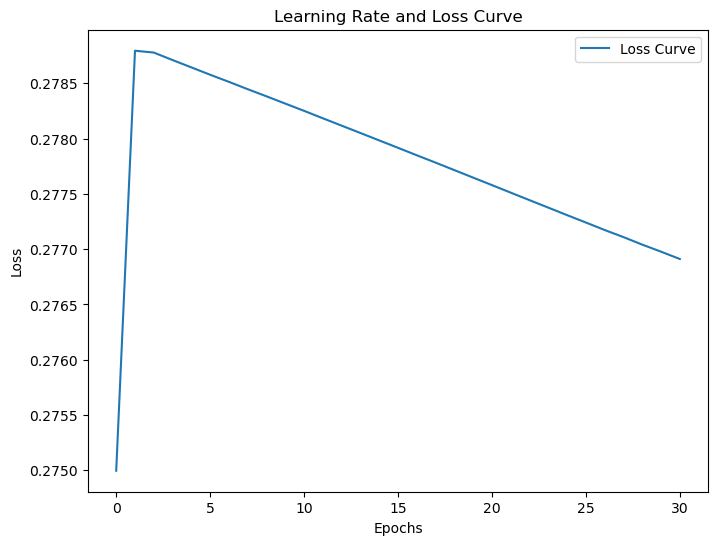

R² prediction score: -76.15140627566593
MSE: 76.47657349228072
MAE: 8.705860998513195


In [15]:
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate_mlp(X_train, y_train, X_test, y_test, X_val, y_val, qt, 
                            activ='tanh', opt='adam', n_epochs=1000, 
                            pat=30, val_split=0.15, n_units1=35, 
                            n_units2=35, batch_size=16, SEED=42):
    """
    Train an MLPRegressor, make predictions, and evaluate performance, including handling class imbalance.
    
    Parameters:
        X_train (pd.DataFrame): Training feature set.
        y_train (pd.Series): Training target set.
        X_test (pd.DataFrame): Test feature set.
        y_test (pd.Series): Test target set.
        X_val (pd.DataFrame): Validation feature set.
        y_val (pd.Series): Validation target set.
        qt (QuantileTransformer): Quantile transformer for inverse transformation.
        activ (str): Activation function for MLP.
        opt (str): Optimizer for MLP.
        n_epochs (int): Number of epochs for MLP.
        pat (int): Patience for early stopping.
        val_split (float): Validation fraction for early stopping.
        n_units1 (int): Number of neurons in first hidden layer.
        n_units2 (int): Number of neurons in second hidden layer.
        batch_size (int): Batch size for training.
        SEED (int): Random seed for reproducibility.
    
    Returns:
        dict: Model evaluation metrics (R², MSE, MAE) and learning rate curve.
    """
    
    # Train MLPRegressor
    regr = MLPRegressor(hidden_layer_sizes=(n_units1, n_units2),
                        activation=activ,
                        solver=opt,
                        max_iter=n_epochs,
                        random_state=SEED,
                        early_stopping=True,
                        n_iter_no_change=pat,
                        validation_fraction=val_split,
                        batch_size=batch_size,
                        warm_start=True,
                        verbose=False)

    # Fit model and keep track of learning curves (loss history)
    loss_curve = []
    for epoch in range(n_epochs):
        regr.fit(X_train, y_train)
        loss_curve.append(regr.loss_)
        
        # Early stopping if the loss curve does not improve
        if len(loss_curve) > pat and loss_curve[-1] >= min(loss_curve[-pat-1:]):
            break
    
    # Predict
    y_pred_transformed = regr.predict(X_test)
    y_pred_transformed = y_pred_transformed.reshape(-1, 1)

    # Inverse transform predictions to original log_eps space
    y_pred = pd.DataFrame(qt.inverse_transform(y_pred_transformed), columns=['log_eps'])

    # Ensure y_test is 1-dimensional for comparison
    y_test = y_test.flatten()  # Flatten y_test to 1D array

    # Evaluate R² score
    u = ((y_test - y_pred['log_eps'].values.flatten()) ** 2).sum()  # Flatten y_pred to 1D array
    v = ((y_test - y_test.mean()) ** 2).sum()
    r2_score = 1 - (u/v)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Plot learning rate curve (loss curve)
    plt.figure(figsize=(8, 6))
    plt.plot(loss_curve, label='Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Rate and Loss Curve')
    plt.legend()
    plt.show()
    
    # Return evaluation metrics and the learning curve
    return {
        "R²": r2_score,
        "MSE": mse,
        "MAE": mae,
        "Loss_Curve": loss_curve
    }

metrics = train_and_evaluate_mlp(df_train_scaled_range, y_train_transformed, df_test_scaled_range, y_test_transformed, df_val_scaled_range, y_val_transformed, qt)

print("R² prediction score:", metrics["R²"])
print("MSE:", metrics["MSE"])
print("MAE:", metrics["MAE"])

#### Hyperparameter tuning

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

In [ ]:
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,1)],
          'activation': ['relu','tanh','logistic'],
          'alpha': [0.0001, 0.05],
          'learning_rate': ['constant','adaptive'],
          'solver': ['adam']}

gsc = GridSearchCV(
    regr,
    param_grid,
    cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

grid_result = gsc.fit(X_train, y_train)

best_params = grid_result.best_params_

best_mlp = MLPRegressor(hidden_layer_sizes = best_params["hidden_layer_sizes"], 
                        activation =best_params["activation"],
                        solver=best_params["solver"],
                        max_iter= 5000, n_iter_no_change = 200
              )

scoring = {
           'abs_error': 'neg_mean_absolute_error',
           'squared_error': 'neg_mean_squared_error',
           'r2':'r2'}

scores = cross_validate(best_mlp, X_train, y_train, cv=10, scoring=scoring,
                        return_train_score=True, return_estimator = True)

/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lb962/miniconda3/envs/ESL/lib/python3.12/site-packages/sklearn/neural_netwo

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert scores to DataFrame
scores_df = pd.DataFrame(scores)

# Create boxplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['abs_error', 'squared_error', 'r2']

for i, metric in enumerate(metrics):
    sns.boxplot(data=scores_df[[f'test_{metric}', f'train_{metric}']], ax=axs[i])
    axs[i].set_title(f'{metric.upper()} across folds')
    axs[i].set_ylabel(metric)
    axs[i].set_xticklabels(['Test', 'Train'])

plt.tight_layout()
plt.show()

# Try Keras

In [28]:
# define artificial neural network
from keras.models import Sequential
from keras.layers import Dense

# create ANN model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(units=5, input_dim=8, kernel_initializer='normal', activation='relu'))
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(units=5, kernel_initializer='normal', activation='tanh'))

# The output neuron is a single fully connected node 
# Since we will be predicting a single number
model.add(Dense(1, kernel_initializer='normal'))

#Compiling the model
model.compile(loss='mean_squared_error', optimizer='adam')

#model.compile(
  #  optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
  #  loss=keras.losses.SparseCategoricalCrossentropy(),
  #  metrics=[keras.metrics.SparseCategoricalAccuracy()],
#)

# Fitting the ANN 
# Split train into validation data as well to monitor validation loss and accuracy
history = model.fit(X_train, y_train, validation_split=0.25, batch_size = 20, epochs = 30, verbose=1)

Epoch 1/30
5644/5644 [==============================] - 14s 2ms/step - loss: 1.4026 - val_loss: 0.3600
Epoch 2/30
5644/5644 [==============================] - 17s 3ms/step - loss: 0.3522 - val_loss: 0.3513
Epoch 3/30
5644/5644 [==============================] - 20s 4ms/step - loss: 0.3421 - val_loss: 0.3332
Epoch 4/30
5644/5644 [==============================] - 13s 2ms/step - loss: 0.3294 - val_loss: 0.3259
Epoch 5/30
5644/5644 [==============================] - 15s 3ms/step - loss: 0.3246 - val_loss: 0.3220
Epoch 6/30
5644/5644 [==============================] - 15s 3ms/step - loss: 0.3216 - val_loss: 0.3235
Epoch 7/30
5644/5644 [==============================] - 17s 3ms/step - loss: 0.3194 - val_loss: 0.3215
Epoch 8/30
5644/5644 [==============================] - 15s 3ms/step - loss: 0.3180 - val_loss: 0.3161
Epoch 9/30
5644/5644 [==============================] - 14s 2ms/step - loss: 0.3171 - val_loss: 0.3158
Epoch 10/30
5644/5644 [==============================] - 13s 2ms/step - l

In [30]:
y_pred = model.predict(X_test)

1176/1176 [==============================] - 2s 1ms/step


In [31]:
scores = model.evaluate(X_test, y_test, verbose=0)

In [34]:
scores

0.31780746579170227

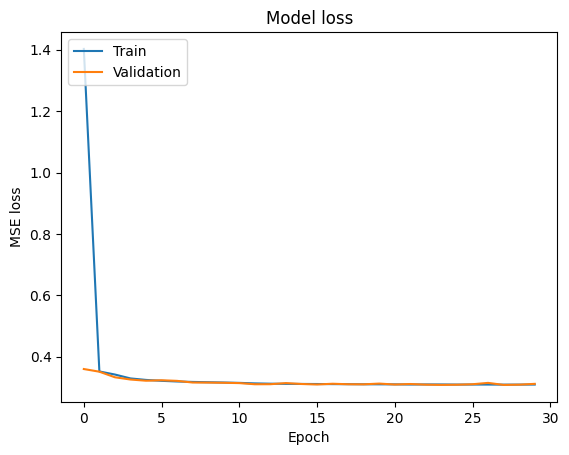

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()